MEM T380

Case Studies Group 10

Ante Sokosa  
Ziad Hatab

Final Project - Weld Defect Classification with Aritifial Neural Networks

In [25]:
# for calculating notebook runtime
import time
start_time = time.time()

In [26]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [27]:


import pandas as pd
from pandas.api.types import CategoricalDtype

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import GridSearchCV



# 1 &nbsp; `Data Exploration (Access, Preprocessimg, and Deriving Features`

Data exploration has been previously explained, discussed, and completed in HW2.  
We are importing this data as explored, cleaned, and prepared with subsets combined.

In [28]:
excel_file = 'weld_defect_dataset.xlsx'

# gather data from excel file
subsets = []
for i in range(1, 6):
    subset = pd.read_excel(excel_file, sheet_name = 'subset' + str(i))
    subset = subset.rename(columns={'Type':'type','W':'w','Ar':'ar','Sp':'sp','Re':'re','Rr':'rr','Sk':'sk','Ku':'ku','Hc':'hc','Rc':'rc','Sc ':'sc','Kc ':'kc'}) # note the space after Sc and Kc are errors in naming in the excel file and are corrected here for ease of use later
    subsets.append(subset)
df = pd.concat(subsets, ignore_index=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

# Features
nums = list(df.select_dtypes(include=['float64']).columns)
standard_scaler = StandardScaler()
df[nums] = standard_scaler.fit_transform(df[nums])

# Target
types = df['type'].unique().tolist()
print('types:',types)
cat_type = CategoricalDtype(categories=types, ordered=True) # specify the order of categories (stop it from going in alphabetical order; good for confusion matricies comparisons to paper later)
df['type'] = df['type'].astype(cat_type) # convert column to categorical type
df['type_copy'] = df['type'] # create column for get_dummies() to work on so that we keep the orignal 'type' columns afterwards
df = pd.get_dummies(df, columns=['type_copy'], prefix=['type']) # get dummies

excel_file_clean = excel_file.split('.')[0]+'_clean.xlsx'
df.to_excel(excel_file_clean, index=False)
df # clean and prepped dataframe

types: ['PO', 'SL', 'LP', 'LF', 'CR']


,type,w,ar,sp,re,rr,sk,ku,hc,rc,sc,kc,type_PO,type_SL,type_LP,type_LF,type_CR
0,PO,-0.874553,-0.786637,-0.116198,1.687500,3.592437,-0.462970,2.014749,-0.646807,-0.608549,0.112723,-0.587744,1,0,0,0,0
1,PO,-0.867095,-0.800094,-0.873054,1.687500,1.916513,-0.783785,-0.847640,-0.649219,-0.550744,0.643202,-0.230305,1,0,0,0,0
2,PO,-0.882011,-0.800094,-0.739818,2.324728,2.420339,-0.729491,1.073546,-0.650634,-0.513391,0.576477,-0.225458,1,0,0,0,0
3,PO,-0.770168,-0.800094,-1.330129,0.540485,-0.903687,0.469655,1.223842,-0.597296,-0.716502,-0.141997,-0.921506,1,0,0,0,0
4,PO,-0.822358,-0.800094,-0.913765,0.625398,-1.020156,2.505449,0.173118,-0.620766,-0.824734,0.211772,-1.363982,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214,CR,0.527210,2.890215,1.974872,-1.089548,2.270158,-0.870020,-0.899740,0.061944,3.128958,-0.064287,0.250808,0,0,0,0,1
215,CR,-0.143847,1.998389,1.005208,-1.268292,1.245591,-0.196870,-0.352191,-0.590920,0.263546,1.189902,0.347742,0,0,0,0,1
216,CR,0.750896,2.488716,0.509273,-1.074733,0.758081,-0.854702,-0.771054,0.713970,3.128171,-0.574069,0.534778,0,0,0,0,1
217,CR,0.758354,1.443158,0.194687,-0.935655,0.645220,-0.780371,-0.740219,0.449058,2.452631,-0.154380,0.593998,0,0,0,0,1


For Reference: 

`Defect Features:`

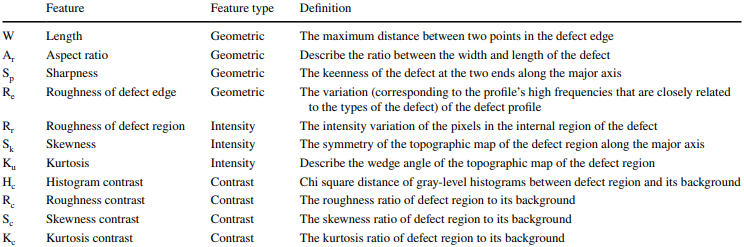

`Defect Types:`  
- `CR` = crack
- `LF` = lack of fusion
- `LP` = lack of penetration
- `PO` = porosity
- `SL` = slag inclusion

Useing `.info()` and `.describe()` for data confirmation and reference:

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219 entries, 0 to 218
Data columns (total 17 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   type     219 non-null    category
 1   w        219 non-null    float64 
 2   ar       219 non-null    float64 
 3   sp       219 non-null    float64 
 4   re       219 non-null    float64 
 5   rr       219 non-null    float64 
 6   sk       219 non-null    float64 
 7   ku       219 non-null    float64 
 8   hc       219 non-null    float64 
 9   rc       219 non-null    float64 
 10  sc       219 non-null    float64 
 11  kc       219 non-null    float64 
 12  type_PO  219 non-null    uint8   
 13  type_SL  219 non-null    uint8   
 14  type_LP  219 non-null    uint8   
 15  type_LF  219 non-null    uint8   
 16  type_CR  219 non-null    uint8   
dtypes: category(1), float64(11), uint8(5)
memory usage: 20.4 KB


In [30]:
df[nums].describe()

,w,ar,sp,re,rr,sk,ku,hc,rc,sc,kc
count,2.190000e+02,2.190000e+02,2.190000e+02,2.190000e+02,2.190000e+02,2.190000e+02,2.190000e+02,2.190000e+02,2.190000e+02,2.190000e+02,2.190000e+02
mean,-8.111218e-18,-3.244487e-17,1.662800e-16,-9.733462e-17,-6.083414e-18,-7.502877e-17,1.022014e-15,3.244487e-17,-4.461170e-17,9.125121e-17,-4.866731e-17
std,1.002291e+00,1.002291e+00,1.002291e+00,1.002291e+00,1.002291e+00,1.002291e+00,1.002291e+00,1.002291e+00,1.002291e+00,1.002291e+00,1.002291e+00
min,-9.118320e-01,-8.000944e-01,-2.658791e+00,-1.475707e+00,-1.198802e+00,-1.012763e+00,-2.886221e+00,-6.694647e-01,-1.228245e+00,-1.672119e+00,-2.987224e+00
25%,-7.254280e-01,-7.653339e-01,-8.526988e-01,-9.823347e-01,-7.802472e-01,-6.275409e-01,-5.615597e-01,-5.772531e-01,-6.256668e-01,-6.639940e-01,-7.075824e-01
50%,-5.091975e-01,-5.683864e-01,-5.883228e-02,6.654728e-02,-1.722487e-01,-3.363570e-01,-2.232333e-01,-4.229268e-01,-3.357616e-01,-1.781106e-01,2.536041e-02
75%,5.272102e-01,6.058740e-01,1.049620e+00,7.977667e-01,4.401597e-01,1.959837e-01,4.299905e-01,1.516094e-01,2.171876e-01,5.471275e-01,6.215435e-01
max,4.285127e+00,3.236178e+00,1.974872e+00,2.324728e+00,3.618412e+00,5.087585e+00,3.966286e+00,6.907185e+00,4.537491e+00,5.315733e+00,3.629988e+00


In [31]:
# sns.pairplot(df, vars=nums, hue='type', diag_kind='kde')

<Axes: >

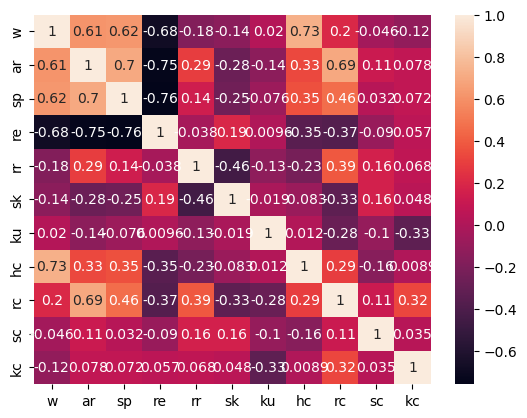

In [32]:
sns.heatmap(df[nums].corr(), annot=True)

# 2 &nbsp; `Train`

We will begin by splitting our data into training and testing sets, using a 20% test size:

In [33]:
X = df.select_dtypes(include=['float64']).values
Y = df.select_dtypes(include=['uint8']).values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)

print(f'X_train shape: {X_train.shape} Type: {type(X_train)}')
print(f'X_test  shape: {X_test.shape}  Type: {type(X_test)}')
print(f'y_train shape: {Y_train.shape}  Type: {type(Y_train)}')
print(f'y_test  shape: {Y_test.shape}   Type: {type(Y_test)}')

n_features = X.shape[1]
n_classes = Y.shape[1]
print('number of features: ', n_features)
print('number of classes : ', n_classes)

X_train shape: (175, 11) Type: <class 'numpy.ndarray'>
X_test  shape: (44, 11)  Type: <class 'numpy.ndarray'>
y_train shape: (175, 5)  Type: <class 'numpy.ndarray'>
y_test  shape: (44, 5)   Type: <class 'numpy.ndarray'>
number of features:  11
number of classes :  5


Construct basic artificial neural network (ANN) model with Keras:

explain why relu and sigmoid - sigmoid needed for outet - relu needed earlier due to vanishing gradient problem it does best on (as in reaserch paper)

We will create a functioin of a basic ANN model and then created differenent instances basese on different params, skips, etc.

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 11)]         0           []                               
                                                                                                  
 dense_22 (Dense)               (None, 6)            72          ['input_4[0][0]']                
                                                                                                  
 dense_24 (Dense)               (None, 5)            35          ['dense_22[0][0]']               
                                                                                                  
 dense_26 (Dense)               (None, 5)            30          ['dense_24[0][0]']               
                                                                                            

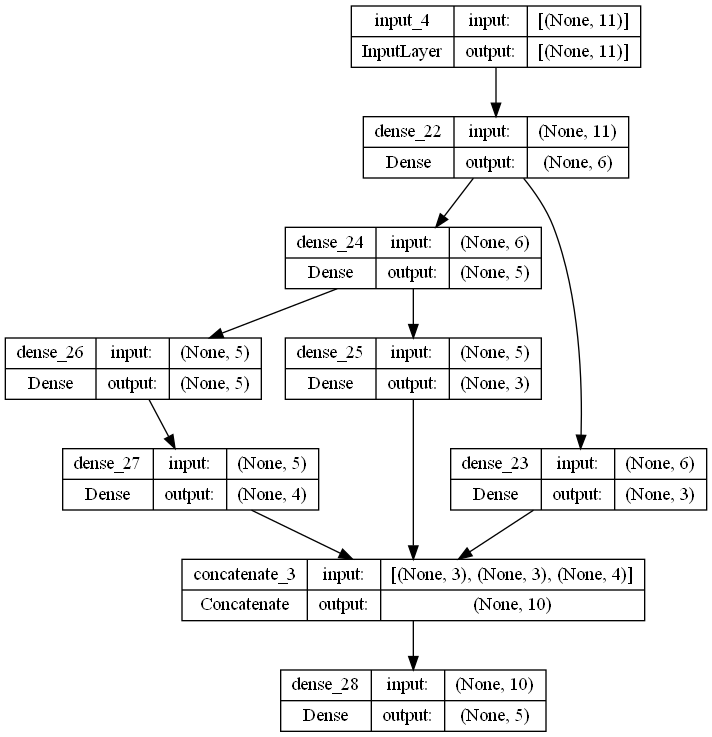

In [34]:
np.random.seed(42)
tf.random.set_seed(42)

def create_keras_model(input_dim=11, output_dim=5, hidden_nodes=[[6, 3], [5, 3], [5, 4]], 
                       optimizer='adam', learning_rate=0.001, regularization_factor=0.01):
    '''
    How to call:
    model_name = create_keras_model(n_features, n_classes, hidden_nodes=[[5, 2], [10, 4], [15, 8]], 
                                    optimizer='adam', learning_rate=0.001, regularization_factor=0.01)
    '''

    # input layer
    inputs = Input(shape=(input_dim,))

    # lists to hold hidden layers
    hidden_layers = []
    compressed_layers = []

    # create hidden layers
    for i in range(len(hidden_nodes)):
        if i == 0:
            # if it's the first hidden layer, connect it to the inputs
            hidden_layers.append(Dense(units=hidden_nodes[i][0], activation='relu', kernel_initializer='random_normal', kernel_regularizer=l2(regularization_factor))(inputs))
        else:
            # otherwise, connect it to the previous hidden layer
            hidden_layers.append(Dense(units=hidden_nodes[i][0], activation='relu', kernel_initializer='random_normal', kernel_regularizer=l2(regularization_factor))(hidden_layers[-1]))
        
        # compression layer
        compressed_layers.append(Dense(units=hidden_nodes[i][1], activation='relu', kernel_initializer='random_normal', kernel_regularizer=l2(regularization_factor))(hidden_layers[-1]))

    # concatenate the compressed layers
    concatenated = concatenate(compressed_layers)

    # output layer, directly connected to the concatenated layer
    outputs = Dense(output_dim, activation='softmax')(concatenated)
    
    # # create hidden layers
    # for i in range(len(hidden_nodes)):
    #     if i == 0:
    #         # if it's the first hidden layer, connect it to the inputs
    #         hidden_layers.append(Dense(units=hidden_nodes[i][0], activation='relu', kernel_initializer='random_normal', kernel_regularizer=l2(regularization_factor))(inputs))
    #     else:
    #         # otherwise, connect it to the previous hidden layer
    #         hidden_layers.append(Dense(units=hidden_nodes[i][0], activation='relu', kernel_initializer='random_normal', kernel_regularizer=l2(regularization_factor))(hidden_layers[-1]))
        
    #     # compression layer
    #     compressed_layers.append(Dense(units=hidden_nodes[i][1], activation='relu', kernel_initializer='random_normal', kernel_regularizer=l2(regularization_factor))(hidden_layers[-1]))

    # # final hidden layer, connected to all compression layers
    # final_hidden = Dense(units=hidden_nodes[-1][1], activation='relu', kernel_initializer='random_normal', kernel_regularizer=l2(regularization_factor))(concatenate(compressed_layers))

    # # output layer, connected to final hidden layer
    # outputs = Dense(output_dim, activation='softmax')(final_hidden)

    # create model
    model = Model(inputs=inputs, outputs=outputs)

    # define optimizer with the given learning rate
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 

    return model

model0 = create_keras_model(n_features, n_classes, hidden_nodes=[[6, 3], [5, 3], [5, 4]],
                                        optimizer='adam', learning_rate=0.001, regularization_factor=0.01)
model0.summary()
plot_model(model0, show_shapes=True)


In [35]:
# Define early stopping callback
early_stop0 = EarlyStopping(monitor='val_loss', patience=50)
# Train the model
model0firstfit = model0.fit(X_train, Y_train, validation_data=(X_test, Y_test), verbose=1, batch_size=1, epochs=1000, callbacks=[early_stop0])

Epoch 1/1000
175/175 [==============================] - 2s 5ms/step - loss: 1.6069 - accuracy: 0.2686 - val_loss: 1.5903 - val_accuracy: 0.3182
Epoch 2/1000
175/175 [==============================] - 0s 3ms/step - loss: 1.5607 - accuracy: 0.3200 - val_loss: 1.5083 - val_accuracy: 0.2727
Epoch 3/1000
175/175 [==============================] - 0s 3ms/step - loss: 1.4615 - accuracy: 0.3314 - val_loss: 1.4086 - val_accuracy: 0.3409
Epoch 4/1000
175/175 [==============================] - 0s 2ms/step - loss: 1.3841 - accuracy: 0.3771 - val_loss: 1.3454 - val_accuracy: 0.3409
Epoch 5/1000
175/175 [==============================] - 0s 2ms/step - loss: 1.3333 - accuracy: 0.3714 - val_loss: 1.3010 - val_accuracy: 0.3409
Epoch 6/1000
175/175 [==============================] - 0s 3ms/step - loss: 1.2917 - accuracy: 0.3886 - val_loss: 1.2642 - val_accuracy: 0.4091
Epoch 7/1000
175/175 [==============================] - 0s 2ms/step - loss: 1.2593 - accuracy: 0.3771 - val_loss: 1.2370 - val_accuracy:

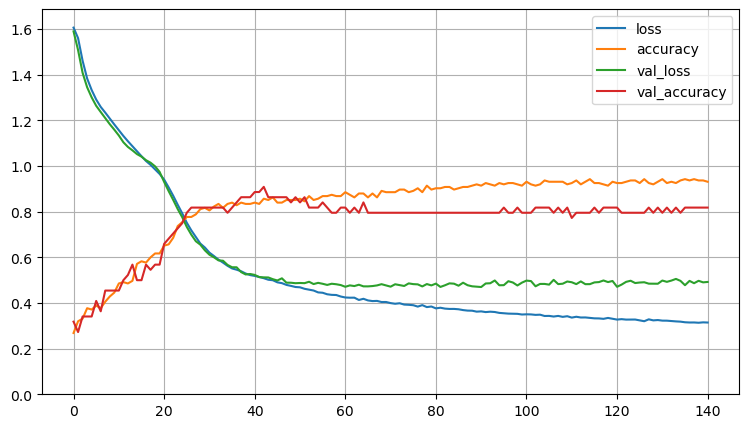

In [36]:
maxes = []
for met in model0firstfit.history.keys():
    maxes.append(max(model0firstfit.history[met]))
mmax = max(maxes)

pd.DataFrame(model0firstfit.history).plot(figsize=(9, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.05*mmax)
plt.show()

In [23]:
# Wrap Keras model with KerasClassifier
model = KerasClassifier(build_fn=create_keras_model, verbose=0) #allows for create_keras_model to be called with additional parameters such as epochs and batch_size

# set parameters
early_stop = EarlyStopping(monitor='val_loss', patience=100)
batch_sizes = [0, 1, 2, 4, 8, 16, 32, 64]
learning_rates = [0.001, 0.01, 0.05, 0.1, 0.5, 1]
regularization_factors = [0.3, 0.25, 0.2, 0.15, 0.1, 0.5, 0.01, 0.05, 0.001, 0.0005]
# batch_sizes = [0, 1, 2, 3, 4, 8, 10, 16, 32, 64, 128, 256, 512]
# learning_rates = [0.001]
# regularization_factors = [0.01]
param_grid = dict(batch_size=batch_sizes, learning_rate=learning_rates, regularization_factor=regularization_factors)

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)
grid_result = grid.fit(X_train, Y_train, callbacks=[early_stop])

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

C:\Users\antes\AppData\Local\Temp\ipykernel_20028\3590851570.py:2: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_keras_model, verbose=0) #allows for create_keras_model to be called with additional parameters such as epochs and batch_size


Best: 0.560000 using {'batch_size': 8, 'learning_rate': 0.1, 'regularization_factor': 0.001}


In [14]:
# # create dataframe from cv_results_
# df = pd.DataFrame(grid_result.cv_results_)

# # pivot as prep for heatmap
# df_pivot = df.pivot(index='param_batch_size', columns='param_epochs', values='mean_test_score')

# # create heatmap
# fig, ax = plt.subplots(figsize=(9, 5))
# sns.heatmap(df_pivot, annot=True, cmap="YlGnBu")
# ax.set_title('Accuracy Heatmap')
# ax.set_ylabel('Batch Size')
# ax.set_xlabel('Epochs')

2/2 [==============================] - 0s 4ms/step


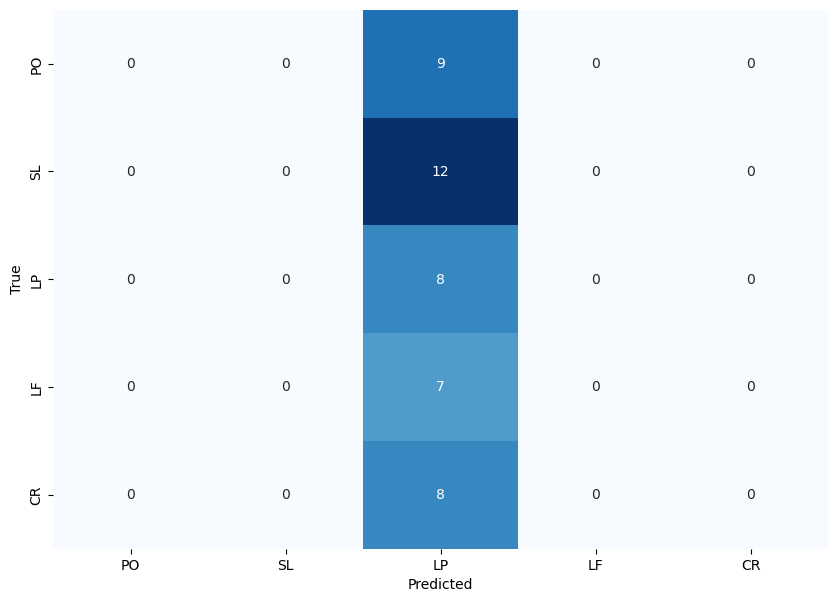

In [15]:
# from sklearn.metrics import accuracy_score

# # get predictions
# y_pred = grid.predict(X_test)

# # get accuracy
# acc = accuracy_score(Y_test, y_pred)

# # print accuracy
# print('Accuracy:', acc)

# # print best parameters
# print('Best Parameters:', grid.best_params_)


from sklearn.metrics import confusion_matrix

# predict classes for test set
Y_pred = model0.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

# convert one-hot encoded test labels back to class labels
y_true = np.argmax(Y_test, axis=1)

# calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=types, yticklabels=types)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [16]:
from sklearn.metrics import classification_report

# print classification report
print(classification_report(y_true, y_pred, target_names=types))

              precision    recall  f1-score   support

          PO       0.00      0.00      0.00         9
          SL       0.00      0.00      0.00        12
          LP       0.18      1.00      0.31         8
          LF       0.00      0.00      0.00         7
          CR       0.00      0.00      0.00         8

    accuracy                           0.18        44
   macro avg       0.04      0.20      0.06        44
weighted avg       0.03      0.18      0.06        44



c:\Users\antes\anaconda3\envs\env0\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\antes\anaconda3\envs\env0\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\antes\anaconda3\envs\env0\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
end_time = time.time()
print(f'Total runtime of this notebook is {(end_time-start_time)/60:0.2f} minutes.')

Total runtime of this notebook is 1.00 minutes.
